In [1]:
import numpy as np
import pandas as pd
import os
from random import shuffle
from tqdm import tqdm

DATA_DIR = '../input/amazon/'
TRAIN_TIF_DIR = DATA_DIR + 'train-tif/'
TRAIN_CSV = DATA_DIR + 'train.csv'
TEST_TIF_DIR = DATA_DIR + 'test-tif/'

IMG_SIZE = 256
LR = 1e-3

MODEL_NAME = 'amazon-{}-{}.model'.format(LR, '6conv-large')

In [2]:
from skimage import io
from scipy.misc import imresize
import cv2
import tifffile as tiff

# convert cloud cover labels to array [clear, cloudy, haze, partly_cloudy]
def get_labels(row):
    labels = np.array([row.clear, 
                       row.cloudy,
                       row.haze,
                       row.partly_cloudy,
                       row.agriculture,
                       row.cultivation,
                       row.habitation,
                       row.primary,
                       row.water,
                       row.road])
    return labels

# load image
# reduce image from 255,255,4 to 100,100,4
# flatten out to 1-D array in order R,G,B,NIR (should we use greyscale instead, ignore NIR?)
def load_image(filename):
    path = os.path.abspath(os.path.join(TRAIN_TIF_DIR, filename))
    if os.path.exists(path):
        img = tiff.imread(path)
        return img
    # if you reach this line, you didn't find the image you're looking for
    print('Load failed: could not find image {}'.format(path))
    
# create training data from train.csv DataFrame
def load_training_data():
    train_images = []

    for index, row in tqdm(train.iterrows()):
        grey_image = load_image(row.image_name + '.tif')
        train_images.append([grey_image, 
                             get_labels(row),
                             row.image_name])

    return train_images

# load test data from test data folder
# reduce image to 100,100,4, flatten etc as above
def create_test_data():
    test_images = []
    
    for image_name in os.listdir(TRAIN_TIF_DIR):
        grey_image = load_image(row.image_name + '.tif')
        test_images.append([grey_image, image_name.split('.')[0]])
        
    return test_images

In [3]:
AVAILABLE_LABELS = [
    'agriculture', 
    'clear', 
    'cloudy', 
    'cultivation', 
    'habitation', 
    'haze', 
    'partly_cloudy', 
    'primary', 
    'road', 
    'water']

# read our data and take a look at what we are dealing with
train_csv = pd.read_csv(TRAIN_CSV)
train_csv.head()

tags = pd.DataFrame()

for label in AVAILABLE_LABELS:
    tags[label] = train_csv.tags.apply(lambda x: np.where(label in x, 1, 0))
    
train_csv = pd.concat([train_csv, tags], axis=1)
train_csv.head(n=2)

,image_name,tags,agriculture,clear,cloudy,cultivation,habitation,haze,partly_cloudy,primary,road,water
0,train_0,haze primary,0,0,0,0,0,1,0,1,0,0
1,train_1,agriculture clear primary water,1,1,0,0,0,0,0,1,0,1


In [10]:
# at this point we have our training data in a list
# [0] - greyscale rgbn image
# [1] - array of labels where clear, cloudy, haze, partly_cloudy
# [2] - name of image, for reference


train_csv[train_csv.clear == 1]

,image_name,tags,agriculture,clear,cloudy,cultivation,habitation,haze,partly_cloudy,primary,road,water
1,train_1,agriculture clear primary water,1,1,0,0,0,0,0,1,0,1
2,train_2,clear primary,0,1,0,0,0,0,0,1,0,0
3,train_3,clear primary,0,1,0,0,0,0,0,1,0,0
4,train_4,agriculture clear habitation primary road,1,1,0,0,1,0,0,1,1,0
6,train_6,agriculture clear cultivation primary water,1,1,0,1,0,0,0,1,0,1
8,train_8,agriculture clear cultivation primary,1,1,0,1,0,0,0,1,0,0
9,train_9,agriculture clear cultivation primary road,1,1,0,1,0,0,0,1,1,0
10,train_10,agriculture clear primary slash_burn water,1,1,0,0,0,0,0,1,0,1
11,train_11,clear primary water,0,1,0,0,0,0,0,1,0,1
13,train_13,clear primary,0,1,0,0,0,0,0,1,0,0


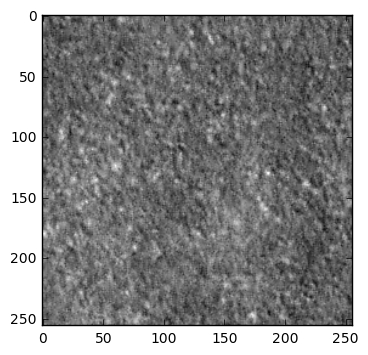

In [9]:
import cv2
import matplotlib.pyplot as plt
import tifffile as tiff

# path = os.path.abspath(os.path.join(TRAIN_TIF_DIR, 'train_3675.tif'))
path = os.path.abspath(os.path.join(TRAIN_TIF_DIR, 'train_0.tif'))
img = tiff.imread(path)[:,:,:4]
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
# if you need to load the training data
# train_images = np.load('training_images.npy')

In [6]:
import tensorflow as tf
tf.reset_default_graph()

In [7]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 4], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 10, activation='sigmoid')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='binary_crossentropy', name='targets')

model = tflearn.DNN(convnet)

In [ ]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [9]:
for batch in range(0,3):
    train = train_csv[batch*800:batch*800 + 800]
    
    train_images = load_training_data()
    
    train_data = train_images[:-160]
    test_data = train_images[-160:]

    X = np.array([i[0] for i in train_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 4)
    y = [i[1] for i in train_data]

    X_test = np.array([i[0] for i in test_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 4)
    y_test = [i[1] for i in test_data]

    model.fit({'input': X}, {'targets': y}, n_epoch=50, validation_set=({'input': X_test}, {'targets': y_test}), 
        snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1  | time: 35.127s
| Adam | epoch: 001 | loss: 0.00000 - acc: 0.0000 -- iter: 064/640


KeyboardInterrupt: 

In [ ]:
model.save('/output/' + MODEL_NAME)